In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa

from other_models.attention.attentive_pooling import AttentionWithContext

import numpy as np
import math
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

from data.pamap2.pamap2 import create_pamap2
from utils import *

In [3]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False, finetuning=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.finetuning = finetuning
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
        batch_x, batch_y = np.array(batch_x), np.array(batch_y)

        if not self.finetuning:
            batch_x = window_warp(batch_x)
            batch_y = batch_y.reshape(-1, 1)

        return batch_x, batch_y

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [4]:
def create_dataset(name, data_type="frequency_100"):
    print("creating dataset")
    if name == "pamap2":
        x_train, y_train = create_pamap2(data=data_type)

        # 80%, 10%, 10% respectively in train, val, test dataset
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=time_int, stratify=y_train)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
        print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
        print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
        print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

        return x_train, y_train, x_val, y_val, x_test, y_test

In [5]:
secs = time.time()
tm = time.localtime(secs)

time_string = time.strftime('%Y%m%d%I%M%S', tm)
time_int = int(time_string) % (2**32 - 1)
time_string = str(time_int)
print('random_state : ' , time_int)

random_state :  4216965584


In [6]:
def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

# class DataAugLayer(tf.keras.models.Model):
#     def __init__(self, input_shape):
#         super(DataAugLayer, self).__init__()
#         timestep, features = input_shape
#         self.seq_num, self.seq_length = 4, timestep//4
#         self.features = features
        
#     def call(self, inputs):
#         x = window_slice(time_warp(inputs))
#         x = tf.keras.layers.Reshape((self.seq_num, self.seq_length, self.features))(x)
        
#         return x

In [7]:
def CNN_Set(input_shape, kernel_size, name="Set"):
    
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, activation="relu")
    conv2 = tf.keras.layers.Conv1D(32, kernel_size=kernel_size, activation="relu")
    dropout = tf.keras.layers.Dropout(0.5)
    maxpooling = tf.keras.layers.MaxPool1D(pool_size=2)
    flatten = tf.keras.layers.Flatten()
    
    x = tf.keras.layers.TimeDistributed(conv1)(inputs)
    x = tf.keras.layers.TimeDistributed(conv2)(x)
    x = tf.keras.layers.TimeDistributed(dropout)(x)
    x = tf.keras.layers.TimeDistributed(maxpooling)(x)
    x = tf.keras.layers.TimeDistributed(flatten)(x)
    
    model = tf.keras.models.Model(inputs, x, name=name)
    return model

def Encoder(input_shape, name="encoder"):
    
    inputs = tf.keras.layers.Input(input_shape)
    reshaped_inputs = tf.keras.layers.Reshape((4, 25, 18))(inputs)
    branch_1 = CNN_Set((4, 25, 18), kernel_size=3, name="branch_1")
    branch_2 = CNN_Set((4, 25, 18), kernel_size=7, name="branch_2")
    branch_3 = CNN_Set((4, 25, 18), kernel_size=11, name="branch_3")

    one = branch_1(reshaped_inputs)
    two = branch_2(reshaped_inputs)
    three = branch_3(reshaped_inputs)
    concat = tf.keras.layers.Concatenate()([one, two, three])
    outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concat)
    outputs =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(outputs)
    model = tf.keras.models.Model(inputs, outputs, name=name)

    return model

def add_projection_head(encoder, input_shape, contrastive_output):
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    features = encoder(inputs)
    # features = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(features)
    outputs = tf.keras.layers.Dense(contrastive_output, activation="relu")(features)
    model = tf.keras.models.Model(
        inputs=inputs, outputs=outputs, name="contrastive"
    )
    return model


def Classifier(input_shape, encoder, n_outputs, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable    
    inputs = tf.keras.layers.Input(input_shape)
    encoded = encoder(inputs)
    x = tf.keras.layers.Dense(128)(encoded)
    x = tf.keras.layers.BatchNormalization()(x)
    classified = tf.keras.layers.Dense(n_outputs, activation="softmax", name="classified")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=classified, name="Classifier")     
    return model

In [8]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

### Create Dataset & Dataloader

In [9]:
dataset_name = "pamap2"  
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(name=dataset_name, data_type="nooverlap")

# contrastive_y_train = np.argmax(frequency_100_y_train, axis=1)
# contrastive_y_val = np.argmax(frequency_100_y_val, axis=1)
# contrastive_y_test = np.argmax(frequency_100_y_test, axis=1)

# print("contrastive_y_train shape : ", frequency_100_y_train.shape)
# print("contrastive_y_val shape : ", frequency_100_y_val.shape)
# print("contrastive_y_test shape : ", frequency_100_y_test.shape)

creating dataset
/home/tolom/20220621/contrastive_frequency
x_train.shape :  (15502, 100, 18) y_train.shape:  (15502,)
x_val.shape   :  (1938, 100, 18) y_val.shape:  (1938,)
x_test.shape  :  (1938, 100, 18) y_test.shape:  (1938,)


In [10]:
train_loader = Dataloader(x_train, y_train, 64, shuffle=True, finetuning=False)
valid_loader = Dataloader(x_val, y_val, 64, finetuning=False)
test_loader = Dataloader(x_test, y_test, 64, finetuning=False)

## Pretrain Contrastive Loss

input shape :  (100, 18)


2022-06-28 02:31:51.423082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 02:31:53.984283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6


Model: "contrastive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 18)]         0         
                                                                 
 encoder (Functional)        (None, 64)                436896    
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
Total params: 445,216
Trainable params: 445,216
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-06-28 02:32:11.062972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-06-28 02:32:20.555076: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


243/243 [==============================] - 54s 123ms/step - loss: 2.7827 - val_loss: 2.4872
Epoch 2/10
243/243 [==============================] - 26s 108ms/step - loss: 2.4527 - val_loss: 2.4102
Epoch 3/10
243/243 [==============================] - 27s 111ms/step - loss: 2.3599 - val_loss: 2.3724
Epoch 4/10
243/243 [==============================] - 27s 111ms/step - loss: 2.3067 - val_loss: 2.3025
Epoch 5/10
243/243 [==============================] - 29s 113ms/step - loss: 2.2746 - val_loss: 2.2972
Epoch 6/10
243/243 [==============================] - 27s 111ms/step - loss: 2.2352 - val_loss: 2.2805
Epoch 7/10
243/243 [==============================] - 27s 110ms/step - loss: 2.2160 - val_loss: 2.2782
Epoch 8/10
243/243 [==============================] - 27s 110ms/step - loss: 2.1903 - val_loss: 2.2669
Epoch 9/10
243/243 [==============================] - 27s 112ms/step - loss: 2.1666 - val_loss: 2.2525
Epoch 10/10
243/243 [==============================] - 27s 110ms/step - loss: 2.1433

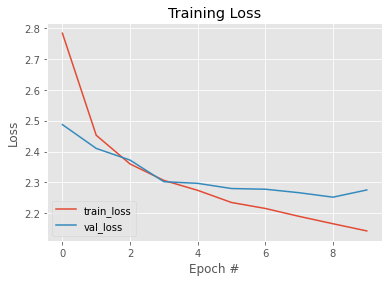

In [11]:
# input_shape = frequency_100_x_train.shape[1:]
input_shape = (100, 18)
print("input shape : ", input_shape)
encoder = Encoder(input_shape)
encoder_with_projection_head = add_projection_head(encoder, input_shape, 128)
encoder_with_projection_head.summary()

encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=SupervisedContrastiveLoss(0.05),
)

history = encoder_with_projection_head.fit(train_loader, validation_data=valid_loader, epochs=10, batch_size=256)
plot_training_loss(history, None)

### Train Dataloader For Classifier finetuning

In [12]:
train_loader.finetuning = True
valid_loader.finetuning = True
test_loader.finetuning = True

### Finetuning Classifier

In [13]:
batch = 400
epcohs = 100
learning_rate = 0.001

filepath = "result/frequency_" + dataset_name + "_" + time_string + ".h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint(filepath, verbose = 0, monitor="val_loss", mode="min", save_best_only=True, save_weights_only = True)

print("[Prtraninig Encoder with Supervised Contrastive Loss]")
model = Classifier(x_train.shape[1:], encoder, len(np.unique(y_train)), trainable=False)
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
# history = model.fit(frequency_100_x_train, [frequency_100_y_train, contrastive_y_train], validation_data=(frequency_100_x_val, [frequency_100_y_val, contrastive_y_val]), batch_size=32, epochs=50, verbose=1, callbacks=[reduce_lr, checkpoint])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch, epochs=epcohs, verbose=1, callbacks=[reduce_lr, checkpoint])
print("[Finished Prtraining]")

[Prtraninig Encoder with Supervised Contrastive Loss]
Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 18)]         0         
                                                                 
 encoder (Functional)        (None, 64)                436896    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 classified (Dense)          (None, 12)                1548      
                                                                 
Total params: 447,276
Trainable params: 10,124
Non-trainable params:

KeyboardInterrupt: 

Random State :  4216963553


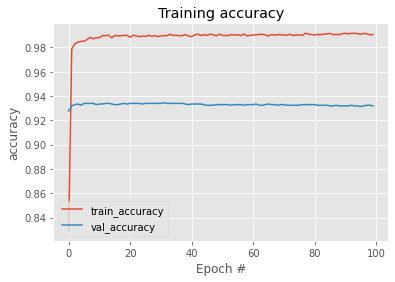

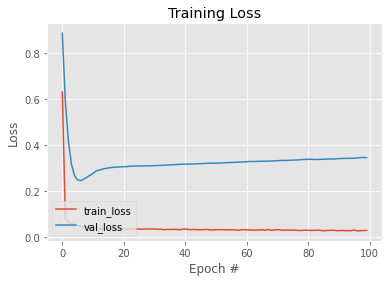

61/61 [==============================] - 1s 9ms/step - loss: 0.2410 - accuracy: 0.9350


AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 432x288 with 0 Axes>

In [ ]:
print("Random State : ", time_string)
plot_training_acc(history, None)
plot_training_loss(history, None)
plt.clf()
print_test_result(model, filepath, x_test, y_test, dataset=dataset_name)